In [2]:
import torch as torch
from network.metric.accuracy import acc_srcnn_tiny_radar
from network.models.classifiers.tiny_radar import TinyRadarNN
from network.models.sr_classifier.SRCnnTinyRadar import CombinedSRCNNClassifier
from network.models.super_resolution.drln import Drln
from network.models.super_resolution.srcnn import SRCnn
from network.runner import Runner
from utils.utils_paths import get_time_in_string
from utils.utils_images import Normalization
import os
import cv2
import numpy as np
from typing import Optional

import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifftshift, ifft
from functools import partial
from multiprocessing import Pool
from data_loader.tiny_loader import *
from data_loader.tiny_radar_loader import *
# from data_loader.tiny_radar_loader import tiny_data_high_res




In [3]:
def process_data(x: np.ndarray) -> np.ndarray:
    # TODO: adding this as preprocess pipeline
    x = np.abs(fftshift(fft(x, axis=0), axes=0))
    x = normalize_img(x, Normalization.Range_0_1)
    x = np.expand_dims(x, axis=0)
    return x
numberOfInstanceWindows = 3
lengthOfSubWindow = 32

gestures = [
        "PinchIndex",
        "PinchPinky",
        # "FingerSlider",
        "FingerRub",
        # "SlowSwipeRL",
        # "FastSwipeRL",
        # "Push",
        # "Pull",
        # "PalmTilt",
        # "Circle",
        # "PalmHold",
        # "NoHand",
    ]
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/data_feat/"
data_dir1 = "/Users/netanelblumenfeld/Desktop/data/11G/data_npy/"
output_dir = "/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs"

people = 2

In [5]:
# #sr 3080
# data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
# data_cfg = DataCfg(task = "sr", gestures = gestures, people = people, data_type="npy", transform_pipeline= process_data)
# train,val,name = get_tiny_dataloader(data_dir=data_dir, data_cfg=data_cfg, pc='3080', test_size=0.1, batch_size=8)

# #sr 4090
# from data_loader.tiny_pipeline import sr_4090_pipeline


# data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
# ds_func = partial(
#     down_sample_data_sr, row_factor=4, col_factor=4, original_dim=False
# )
# norm_func = partial(normalize_img, pix_norm=Normalization.Range_0_1)
# load_data_func = partial(
#     sr_4090_pipeline, norm_func=norm_func, down_sample_func=ds_func
# )
# data_cfg = DataCfg(task = "sr", gestures = gestures, people = people, data_type="npy", transform_pipeline= load_data_func)
# train,val,name = get_tiny_dataloader(data_dir=data_dir, data_cfg=data_cfg, pc='4090', test_size=0.1, batch_size=8)

# # classifier
# from data_loader.tiny_pipeline import classifier_pipeline

# norm_func = partial(normalize_img, pix_norm=Normalization.Range_0_1)
# load_data_func = partial(
#     classifier_pipeline, norm_func=norm_func
# )
# data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
# data_cfg = DataCfg(task = "classifier", gestures = gestures, people = people, data_type="npy", transform_pipeline= load_data_func)
# train,val,name = get_tiny_dataloader(data_dir=data_dir, data_cfg=data_cfg, pc='3080', test_size=0.1, batch_size=8)

# # sr_classifier 3080
# from data_loader.tiny_pipeline import sr_classifier_3080_pipeline
# ds_func = partial(
#     down_sample_data_sr, row_factor=4, col_factor=4, original_dim=False
# )
# norm_func = partial(normalize_img, pix_norm=Normalization.Range_0_1)
# load_data_func = partial(
#     sr_classifier_3080_pipeline, norm_func=norm_func, down_sample_func=ds_func
# )

# data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
# data_cfg = DataCfg(task = "sr_classifier", gestures = gestures, people = people, data_type="npy", transform_pipeline= load_data_func)
# train,val = get_tiny_dataloader(data_dir=data_dir, data_cfg=data_cfg, pc='3080', test_size=0.1, batch_size=8)

# #sr_classifier_4090
from data_loader.tiny_pipeline import sr_classifier_4090_pipeline


ds_func = partial(
    down_sample_data_sr, row_factor=4, col_factor=4, original_dim=False
)
norm_func = partial(normalize_img, pix_norm=Normalization.Range_0_1)
load_data_func = partial(
    sr_classifier_4090_pipeline, norm_func=norm_func, down_sample_func=ds_func, gestures=gestures
)

data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
data_cfg = DataCfg(task = "sr_classifier", gestures = gestures, people = people, data_type="npy", transform_pipeline= load_data_func)
train,val = get_tiny_dataloader(data_dir=data_dir, data_cfg=data_cfg, pc='4090', test_size=0.1, batch_size=8)



People: 2, Gestures: ['PinchIndex', 'PinchPinky', 'FingerRub'], Batch Size: 8
down sampling data with 8 cpu cores
shapess - (105, 5, 2, 8, 123),(105, 5, 2, 32, 492), (105, 5, 3) 
shapess - (105, 5, 2, 8, 123),(105, 5, 2, 32, 492), (105, 5, 3) 
shapess - (105, 5, 2, 8, 123),(105, 5, 2, 32, 492), (105, 5, 3) 
shapes low_res - (315, 5, 2, 32, 492), high_res - (315, 5, 2, 8, 123), labels - (315, 5, 3)


In [4]:

model = Drln(2)
optimizer = torch.optim.Adam
path = "/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs/models/sr/Drln_2/11G_normalization.range_0_1/lr_0.0015_batch_size_128_loss_L1/2023-12-31_12:10:32min_loss_model.pt"
a,b,c,d = model.load_model(path,optimizer,optimizer_args={'lr':0.002},device = torch.device('cpu'))
d,c,b

# data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"

# data = dataset_tiny_sr_off_disk(data_dir, people, gestures,8,Normalization.Range_0_1)
# for x,y in data[0]:
#     print(x.shape)
#     print(y.shape)
#     break


(0.4599326422873964,
 204,
 Adam (
 Parameter Group 0
     amsgrad: True
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     initial_lr: 0.0015
     lr: 0.0005395102885730106
     maximize: False
     weight_decay: 0
 ))

In [5]:
for x,y in train:
    print(x.shape)
    print(y[0].shape)
    print(y[1].shape)
    break

torch.Size([8, 5, 2, 32, 492])
torch.Size([8, 5, 2, 8, 123])
torch.Size([8, 5, 3])


In [6]:
low_res = torch.Tensor(np.expand_dims(np.expand_dims(x[0,0,0],axis=0),axis=0))
low_res.shape

torch.Size([1, 1, 32, 492])

In [ ]:
res = a(x).detach().numpy()
# evaluation(x[0],y[0],res[0])

In [ ]:
x.shape

Text(0.5, 1.0, 'low res')

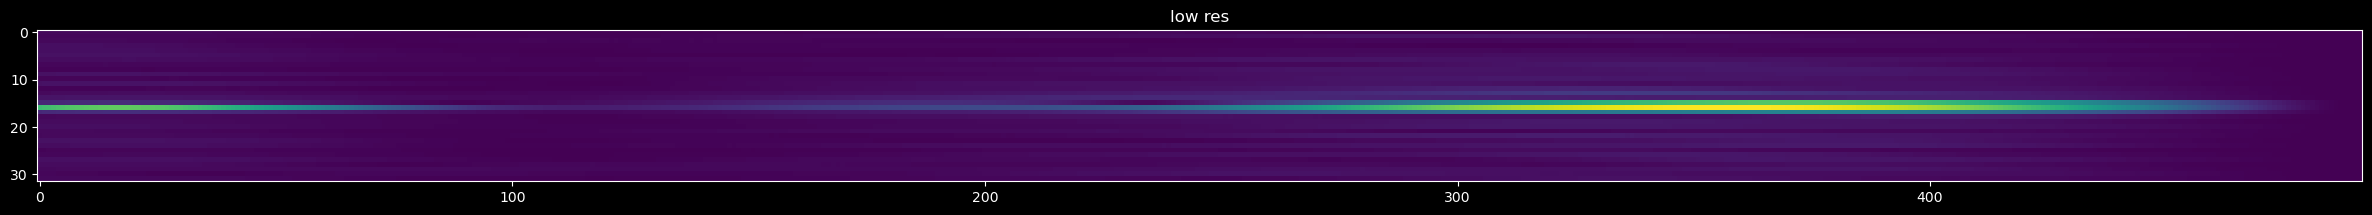

In [7]:
k=2

plt.figure(figsize=(30,30))
plt.imshow(x[0,0,0])
plt.title("low res")

Text(0.5, 1.0, 'high res true')

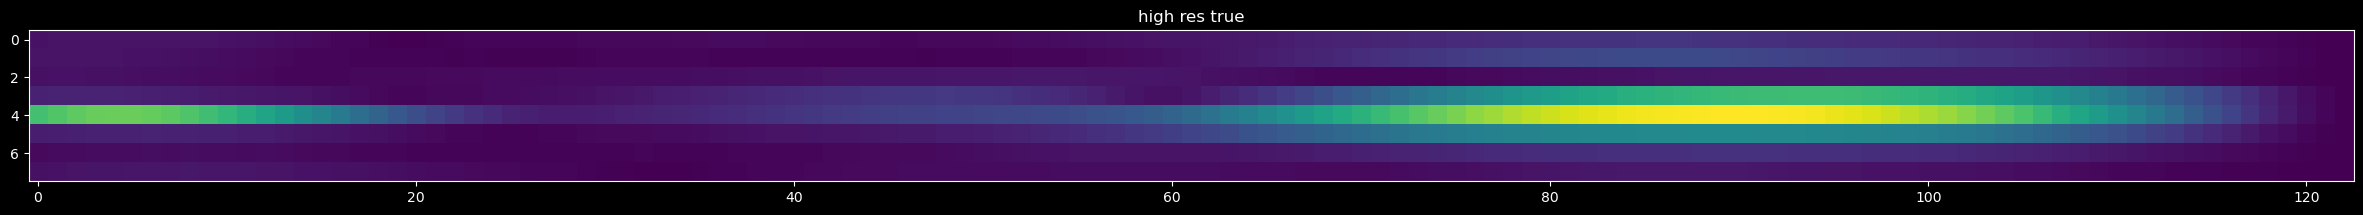

In [8]:
plt.figure(figsize=(30,30))
plt.imshow(y[0][0,0,0])
plt.title("high res true")


In [9]:
plt.figure(figsize=(30,30))
plt.imshow(res[0,0])
plt.title("high res pred")
loss = torch.nn.L1Loss()

# print(loss(y[0][k,0],res[k,0]).item())



NameError: name 'res' is not defined

<Figure size 3000x3000 with 0 Axes>

In [ ]:
low_up = cv2.resize(x[k,0].detach().numpy(), (492,32), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(30,30))
plt.imshow(low_up)


In [ ]:
zero = torch.zeros(1,1,32//4,492//4)
res_zero = a(zero)
plt.figure(figsize=(30,30))
plt.imshow(res_zero[0,0].detach().numpy())

In [ ]:
res_zero.shape, zero.shape

In [ ]:
loss= torch.nn.L1Loss()
loss( torch.zeros(1,1,32//1,492//1),res_zero[0,0])

In [ ]:
numberOfInstanceWindows = 3
lengthOfSubWindow = 32

gestures = [
        "PinchIndex",
        "PinchPinky",
        # "FingerSlider",
        # "FingerRub",
        # "SlowSwipeRL",
        # "FastSwipeRL",
        # "Push",
        # "Pull",
        # "PalmTilt",
        # "Circle",
        # "PalmHold",
        # "NoHand",
    ]
people = 2

data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/data_feat/"
data_dir1 = "/Users/netanelblumenfeld/Desktop/data/11G/data_npy/"
output_dir = "/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs"



# data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"

In [ ]:
diameter_mm = [15,15,24,13]
depth_mm = [110,220,180,180]
price = [44,61,71,55]